In [ ]:
from google.colab import drive
drive.mount('/content/drive')

img_dir = "/content/drive/My Drive/sample_paddy"
annotation_file_path = "/content/drive/My Drive/annotations.json"

Mounted at /content/drive


In [ ]:
# Necessary Installations

# Install additional dependencies
!pip install distinctipy jupyter tqdm
# Custom packages from CJ Mills implementation, fully referenced in bibliography
!pip install cjm_pil_utils cjm_psl_utils cjm_pytorch_utils cjm_torchvision_tfms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
  Attempting unins

In [ ]:
# Necessary Imports
from google.colab import drive

# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm



In [ ]:
# Confirmation of mounted folder and annotations
pd.Series({
    "Image Folder": img_dir,
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,/content/drive/My Drive/sample_paddy
Annotation File,/content/drive/My Drive/annotations.json


In [ ]:
# Confirming image files in the 'img_dir' directory
img_dict = {
    file.stem : file
    for file in get_img_files(img_dir)
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 14


,0
00000000,/content/drive/My Drive/sample_paddy/00000000.jpg
00000008,/content/drive/My Drive/sample_paddy/00000008.jpg
00000002,/content/drive/My Drive/sample_paddy/00000002.jpg
00000018,/content/drive/My Drive/sample_paddy/00000018.jpg
00000020,/content/drive/My Drive/sample_paddy/00000020.jpg


In [ ]:
# Read the annotation data from JSON file into a DataFrame

annotation_file_df = pd.read_json(annotation_file_path, orient='index').transpose()
annotation_file_df.head()

,licenses,info,categories,images,annotations
0,"{'name': '', 'id': 0, 'url': ''}",contributor,"{'id': 1, 'name': 'PEST', 'supercategory': ''}","{'id': 1, 'width': 896, 'height': 843, 'file_name': '00000000.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[132.2, 456.98, 190.85, 343.76, 129.47, 261.92, 327.26, 257.83, 575.52, 311.03, 735.12, 366.95, 815.6, 391.51, 810.14, 421.52, 711.93, 416.06, 632.81, 544.28, 608.26, 526.55, 660.09, 441.98, 455.48, 485.63, 426.84, 518.37, 396.83, 517.0, 422.74, 489.72, 200.4, 489.72, 133.56, 458.35]], 'area': 110885.0, 'bbox': [129.47, 257.83, 686.13, 286.45], 'iscrowd': 0, 'attributes': {'occluded': False}}"
1,None,date_created,None,"{'id': 2, 'width': 300, 'height': 450, 'file_name': '00000002.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 2, 'image_id': 2, 'category_id': 1, 'segmentation': [[99.39, 269.78, 105.95, 234.1, 119.78, 210.07, 143.81, 206.43, 135.07, 234.83, 115.41, 265.41, 113.23, 289.44, 99.39, 269.05]], 'area': 1577.0, 'bbox': [99.39, 206.43, 44.42, 83.01], 'iscrowd': 0, 'attributes': {'occluded': False}}"
2,None,description,None,"{'id': 3, 'width': 200, 'height': 150, 'file_name': '00000006.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 3, 'image_id': 3, 'category_id': 1, 'segmentation': [[90.41, 87.74, 106.68, 42.6, 121.72, 44.78, 116.87, 71.48, 112.5, 90.66, 101.09, 99.64, 90.17, 96.0, 90.41, 87.74]], 'area': 1052.0, 'bbox': [90.17, 42.6, 31.55, 57.04], 'iscrowd': 0, 'attributes': {'occluded': False}}"
3,None,url,None,"{'id': 4, 'width': 1023, 'height': 682, 'file_name': '00000008.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 4, 'image_id': 4, 'category_id': 1, 'segmentation': [[337.12, 380.16, 362.5, 211.31, 323.88, 200.28, 308.43, 287.46, 298.49, 351.47, 298.49, 381.26, 334.91, 381.26]], 'area': 7376.0, 'bbox': [298.49, 200.28, 64.01, 180.98], 'iscrowd': 0, 'attributes': {'occluded': False}}"
4,None,version,None,"{'id': 5, 'width': 1200, 'height': 900, 'file_name': '00000012.JPG', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 5, 'image_id': 5, 'category_id': 1, 'segmentation': [[561.41, 447.82, 610.92, 322.57, 612.38, 179.85, 594.9, 108.5, 542.48, 117.23, 514.81, 165.29, 513.35, 248.3, 523.54, 334.22, 522.09, 398.3, 562.86, 450.73]], 'area': 25888.0, 'bbox': [513.35, 108.5, 99.03, 342.23], 'iscrowd': 0, 'attributes': {'occluded': False}}"


In [ ]:
# Extracting category from annotation DataFrame. Note: This project only consists
# of 1 category i.e. "PEST"
categories_df = annotation_file_df['categories'].dropna().apply(pd.Series)
categories_df.set_index('id', inplace=True)
categories_df

,name,supercategory
id,,
1,PEST,


In [ ]:
# Extracting the 'images' section of the data from annotations
# This DataFrame contains image details like file name, height, width, and image ID
images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
images_df.head()

,file_name,height,width,id
0,00000000.jpg,843.0,896.0,1.0
1,00000002.jpg,450.0,300.0,2.0
2,00000006.jpg,150.0,200.0,3.0
3,00000008.jpg,682.0,1023.0,4.0
4,00000012.JPG,900.0,1200.0,5.0


In [ ]:
# Extracting the 'annotations' section of the data from json data frame
# This DataFrame contains annotation details like image ID, segmentation points, bounding box, and category ID
annotations_df = annotation_file_df['annotations'].to_frame()['annotations'].apply(pd.Series)[['image_id', 'segmentation', 'bbox', 'category_id']]
annotations_df.head()

,image_id,segmentation,bbox,category_id
0,1,"[[132.2, 456.98, 190.85, 343.76, 129.47, 261.92, 327.26, 257.83, 575.52, 311.03, 735.12, 366.95, 815.6, 391.51, 810.14, 421.52, 711.93, 416.06, 632.81, 544.28, 608.26, 526.55, 660.09, 441.98, 455.48, 485.63, 426.84, 518.37, 396.83, 517.0, 422.74, 489.72, 200.4, 489.72, 133.56, 458.35]]","[129.47, 257.83, 686.13, 286.45]",1
1,2,"[[99.39, 269.78, 105.95, 234.1, 119.78, 210.07, 143.81, 206.43, 135.07, 234.83, 115.41, 265.41, 113.23, 289.44, 99.39, 269.05]]","[99.39, 206.43, 44.42, 83.01]",1
2,3,"[[90.41, 87.74, 106.68, 42.6, 121.72, 44.78, 116.87, 71.48, 112.5, 90.66, 101.09, 99.64, 90.17, 96.0, 90.41, 87.74]]","[90.17, 42.6, 31.55, 57.04]",1
3,4,"[[337.12, 380.16, 362.5, 211.31, 323.88, 200.28, 308.43, 287.46, 298.49, 351.47, 298.49, 381.26, 334.91, 381.26]]","[298.49, 200.28, 64.01, 180.98]",1
4,5,"[[561.41, 447.82, 610.92, 322.57, 612.38, 179.85, 594.9, 108.5, 542.48, 117.23, 514.81, 165.29, 513.35, 248.3, 523.54, 334.22, 522.09, 398.3, 562.86, 450.73]]","[513.35, 108.5, 99.03, 342.23]",1


In [ ]:
# Map 'category_id' in annotations DataFrame to category name using categories DataFrame
annotations_df['label'] = annotations_df['category_id'].apply(lambda x: categories_df.loc[x]['name'] if pd.notna(x) else np.nan)

# Merge annotations DataFrame with images DataFrame on their image ID
annotation_df = pd.merge(annotations_df, images_df, left_on='image_id', right_on='id')

# Remove old 'id' column post-merge
annotation_df.drop('id', axis=1, inplace=True)

# Extract the image_id from the file_name (assuming file_name contains the image_id)
annotation_df['image_id'] = annotation_df['file_name'].apply(lambda x: x.split('.')[0])

# Set 'image_id' as the index for the DataFrame
annotation_df.set_index('image_id', inplace=True)

# Group the data by 'image_id' and aggregate information
annotation_df = annotation_df.groupby('image_id').agg({
    'segmentation': list, 'bbox': list,
    'category_id': list, 'label' :list,
    'file_name': 'first', 'height': 'first', 'width': 'first'
})

# Rename columns for clarity
# 'bbox' is renamed to 'bboxes' and 'label' to 'labels'
annotation_df.rename(columns={'bbox': 'bboxes', 'label': 'labels'}, inplace=True)
annotation_df.head()


,segmentation,bboxes,category_id,labels,file_name,height,width
image_id,,,,,,,
00000000,"[[[132.2, 456.98, 190.85, 343.76, 129.47, 261.92, 327.26, 257.83, 575.52, 311.03, 735.12, 366.95, 815.6, 391.51, 810.14, 421.52, 711.93, 416.06, 632.81, 544.28, 608.26, 526.55, 660.09, 441.98, 455.48, 485.63, 426.84, 518.37, 396.83, 517.0, 422.74, 489.72, 200.4, 489.72, 133.56, 458.35]]]","[[129.47, 257.83, 686.13, 286.45]]",[1],[PEST],00000000.jpg,843.0,896.0
00000002,"[[[99.39, 269.78, 105.95, 234.1, 119.78, 210.07, 143.81, 206.43, 135.07, 234.83, 115.41, 265.41, 113.23, 289.44, 99.39, 269.05]]]","[[99.39, 206.43, 44.42, 83.01]]",[1],[PEST],00000002.jpg,450.0,300.0
00000006,"[[[90.41, 87.74, 106.68, 42.6, 121.72, 44.78, 116.87, 71.48, 112.5, 90.66, 101.09, 99.64, 90.17, 96.0, 90.41, 87.74]]]","[[90.17, 42.6, 31.55, 57.04]]",[1],[PEST],00000006.jpg,150.0,200.0
00000008,"[[[337.12, 380.16, 362.5, 211.31, 323.88, 200.28, 308.43, 287.46, 298.49, 351.47, 298.49, 381.26, 334.91, 381.26]]]","[[298.49, 200.28, 64.01, 180.98]]",[1],[PEST],00000008.jpg,682.0,1023.0
00000012,"[[[561.41, 447.82, 610.92, 322.57, 612.38, 179.85, 594.9, 108.5, 542.48, 117.23, 514.81, 165.29, 513.35, 248.3, 523.54, 334.22, 522.09, 398.3, 562.86, 450.73]], [[635.68, 539.56, 673.54, 597.82, 670.63, 667.72, 661.89, 794.42, 619.66, 822.09, 590.53, 819.17, 581.8, 669.17, 574.51, 587.62, 590.53, 546.84, 619.66, 533.74]]]","[[513.35, 108.5, 99.03, 342.23], [574.51, 533.74, 99.03, 288.35]]","[1, 1]","[PEST, PEST]",00000012.JPG,900.0,1200.0


In [ ]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotation_df['labels'].explode().unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,PEST


Image Dims: (896, 843)


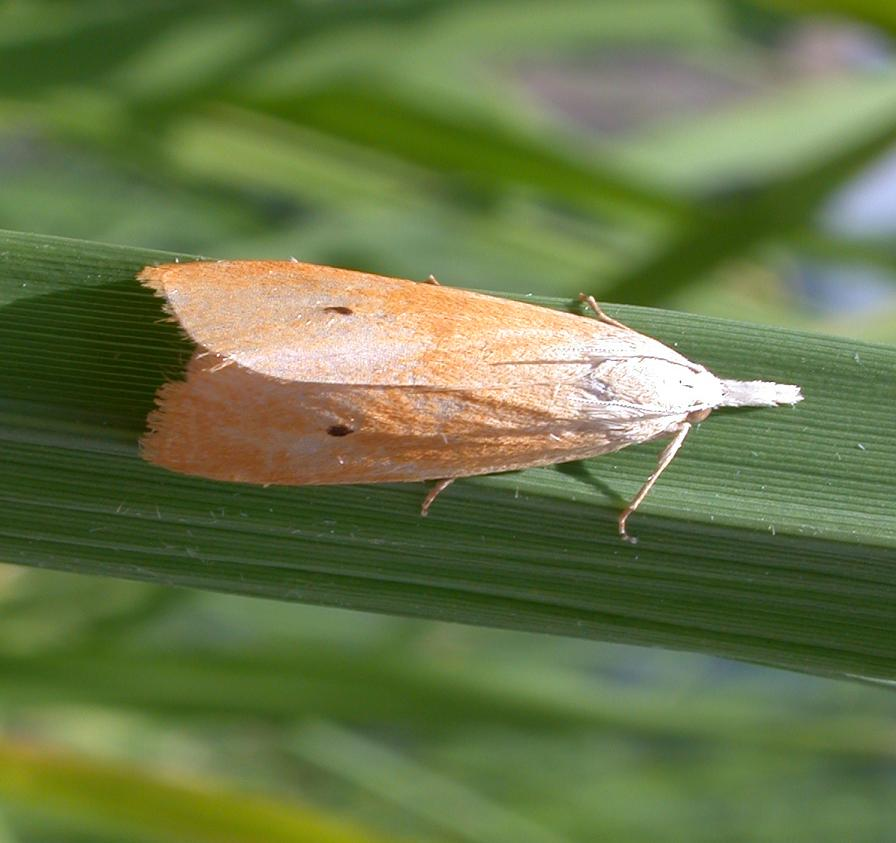

In [ ]:
# Image ID of the fifth image in the sample
image_id = list(img_dict.keys())[0]

# Opening the image
sample_img = Image.open(img_dict[image_id]).convert('RGB')

# Image dimensions
print(f"Image Dims: {sample_img.size}")

sample_img

In [ ]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'image_id'
annotation_df.loc[image_id].to_frame()

,00000000
segmentation,"[[[132.2, 456.98, 190.85, 343.76, 129.47, 261.92, 327.26, 257.83, 575.52, 311.03, 735.12, 366.95, 815.6, 391.51, 810.14, 421.52, 711.93, 416.06, 632.81, 544.28, 608.26, 526.55, 660.09, 441.98, 455.48, 485.63, 426.84, 518.37, 396.83, 517.0, 422.74, 489.72, 200.4, 489.72, 133.56, 458.35]]]"
bboxes,"[[129.47, 257.83, 686.13, 286.45]]"
category_id,[1]
labels,[PEST]
file_name,00000000.jpg
height,843.0
width,896.0


In [ ]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


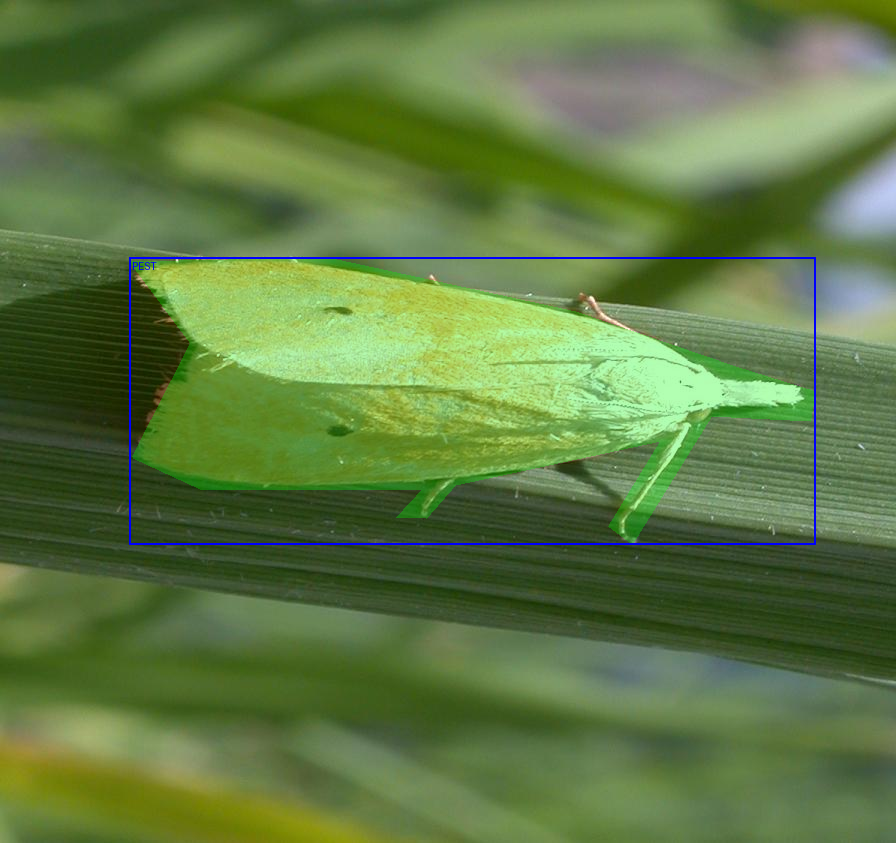

In [ ]:
# The polygonal annotation points for sample pest from the DataFrame
polygon_points = annotation_df.loc[image_id]['segmentation']

# Using create_polygon_mask function from above to create mask images
mask_imgs = [create_polygon_mask(sample_img.size, polygon[0]) for polygon in polygon_points]

# Converting the mask_images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

# Masking the image with the tensor created with the polygonal annotations.
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[(0, 255, 0)],

)

# The label and bounding boxes coordinates for the sample image
labels = annotation_df.loc[image_id]['labels']
bboxes = annotation_df.loc[image_id]['bboxes']

# Annotating the image with the bounding box coordinates and the label
annotated_tensor = draw_bounding_boxes(
    image=annotated_tensor,
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
    labels=labels,
    colors=[(0, 0, 255)],
    width=2,
    font_size=100
)

# Print the annotated sample image
tensor_to_pil(annotated_tensor)

In [ ]:
train_sz = 384
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=1.0,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

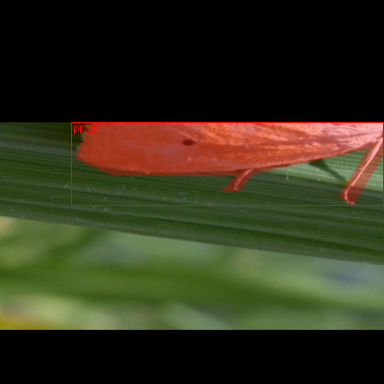

Source Image:,"(896, 843)"
Cropped Image:,"(691, 373)"
Resized Image:,"(383, 207)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [ ]:
# Get colors for dataset sample
sample_colors = [(255,0,0)]

# Prepare bounding box targets
targets = {
    'masks': Mask(masks),
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
                           format='xyxy',
                           canvas_size=sample_img.size[::-1]),
    'labels': torch.Tensor(1)
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3,
    colors=sample_colors
)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']],
    colors=[(255,0,0)]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

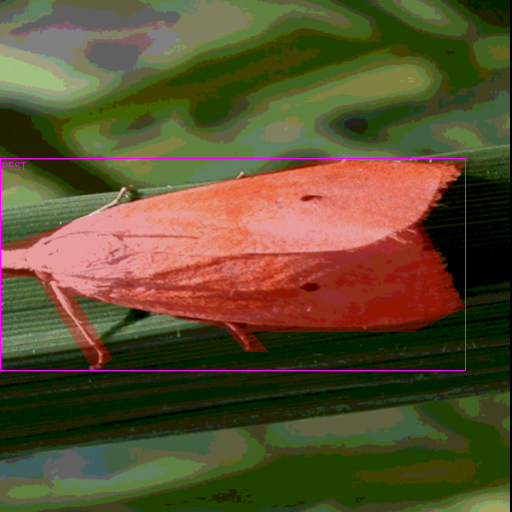

Source Image:,"(896, 843)"
Cropped Image:,"(688, 692)"
Resized Image:,"(509, 511)"
Padded Image:,"(511, 511)"
Resized Padded Image:,"(512, 512)"


In [ ]:
# Data Augmentation with sample picture

train_sz = 512


# Prepare bounding box targets
targets = {
    'masks': Mask(masks),
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
                           format='xyxy',
                           canvas_size=sample_img.size[::-1]),
    'labels': torch.Tensor(1)
}

# Create RandomIoUCrop object and pass the sample image and the targets
random_iou_crop = transforms.RandomIoUCrop()

# Crop the image
cropped_img, targets = random_iou_crop(sample_img, targets)



# Object creation for flipping images horizontally at 0.5 rate
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)

# Random Horizontal Flip
flipped_image, flipped_target = random_horizontal_flip(cropped_img, targets)



# Color Jitter Object with range of color features changing possibilities
color_jitter = transforms.ColorJitter(
    brightness = (0.875, 1.125),
    contrast = (0.5, 1.5),
    saturation = (0.5, 1.5),
    hue = (-0.05, 0.05))

# Color Jitter
jittered_image = color_jitter(flipped_image)



# Random Gray Scale transformation object
random_gray_scale = transforms.RandomGrayscale()

# Gray Scaled
gray_scaled_image = random_gray_scale(jittered_image)




# Random Equalizer transformation object
random_equalize = transforms.RandomEqualize()

# Random Equalize
equalized_image = random_equalize(gray_scaled_image)



# Randdom Posterize transformation object with 0.5 rate
random_posterize = transforms.RandomPosterize(bits=3, p=0.5)

# Random Posterize
posterized_image = random_posterize(equalized_image)



# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Resize the image
resized_img, targets = resize_max(posterized_image, flipped_target)



# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)


# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3,
    colors=[(255, 0, 0)]
)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=labels,
    colors=[(255,0,255)]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')


In [ ]:
# Model Implementation/Development


In [ ]:
import random

# List of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Dataset Split into 80 percent for training and 20 percent for validation
training_percent = 0.8
validation_percent = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*training_percent)
val_split = int(len(img_keys)*(training_percent+validation_percent))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Training Samples:,11
Validation Samples:,3


In [ ]:
class PestDetectionDataset(Dataset):
    """
    A PyTorch Dataset class for COCO-style instance segmentation.

    This class is designed to handle datasets for instance segmentation tasks, specifically
    formatted in the style of COCO (Common Objects in Context) annotations. It supports
    loading images along with their corresponding segmentation masks and bounding boxes.

    Attributes:
    _img_keys : list
        List of image keys (identifiers).
    _annotation_df : pandas.DataFrame
        DataFrame containing annotations for images.
    _img_dict : dict
        Dictionary mapping image keys to their file paths.
    _class_to_idx : dict
        Dictionary mapping class names to class indices.
    _transforms : torchvision.transforms (optional)
        Transformations to be applied to the images and targets.

    Methods:
    __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        Initializes the dataset with image keys, annotations, image dictionary,
        class mappings, and optional transforms.
    __len__(self):
        Returns the total number of items in the dataset.
    __getitem__(self, index):
        Retrieves an image and its corresponding target (masks, boxes, labels) by index.
    _load_image_and_target(self, annotation):
        Loads an image and its corresponding target data based on the providedannotation.

    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the COCOInstSegDataset instance.

        Parameters:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing image annotations.
            img_dict (dict): Dictionary mapping image keys to file paths.
            class_to_idx (dict): Dictionary mapping class names to indices.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()

        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied

    def __len__(self):
        # Returns the number of items in the dataset
        return len(self._img_keys)

    def __getitem__(self, index):
        # Retrieves an image and its corresponding target by index
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)

        # Apply transformations if any
        if self._transforms:
            image, target = self._transforms(image, target)

        return image, target


    def _load_image_and_target(self, annotation):
        # Loads an image and its corresponding target data (masks, boxes, labels)
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Process segmentation polygons
        polygon_points = annotation['segmentation']
        mask_imgs = [create_polygon_mask(image.size, polygon[0]) for polygon in polygon_points]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

        # Convert bounding boxes to tensor format
        bbox_list = annotation['bboxes']
        bbox_tensor = torchvision.ops.box_convert(torch.Tensor(bbox_list), 'xywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])

        # Map labels to their corresponding indices
        annotation_labels = annotation['labels']
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])
        labels = labels.to(dtype=torch.int64)


        return image, {'masks': masks, 'boxes': boxes, 'labels': labels}

In [ ]:
# Compose transforms for data augmentation
data_augmentation = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Transformations for training dataset
training_transformations = transforms.Compose([
    data_augmentation,
    resize_pad_tfm,
    final_tfms
])

# Transformation for validation dataset without augmentation applied
validation_transformations = transforms.Compose([resize_pad_tfm, final_tfms])

In [ ]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = PestDetectionDataset(train_keys, annotation_df, img_dict, class_to_idx, training_transformations)
valid_dataset = PestDetectionDataset(val_keys, annotation_df, img_dict, class_to_idx, validation_transformations)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,11
Validation dataset size:,3


In [ ]:
# Data loader initialization

In [ ]:
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device

device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# Loading the model
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:04<00:00, 45.4MB/s]


In [ ]:
# Initialize Data Loader

import multiprocessing

# Set the training batch size
batch_size = 4

# Set the number of worker processes for loading data.
number_of_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': number_of_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,
    'pin_memory': 'cuda' in device,
    'pin_memory_device': device if 'cuda' in device else '',
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

# Creates DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Creates DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,3
Number of batches in validation DataLoader:,1


In [ ]:
from torch.amp import autocast
import math, json

# Training Loop
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):

    # Set the model to training mode
    model.train()

    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar

    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item

        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar
    progress_bar.close()

    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

In [ ]:
def train_loop(model, train_dataloader, valid_dataloader, optimizer,
               lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):

    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

In [ ]:
# Training Parameters

# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

In [ ]:
import datetime
from pathlib import Path

# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

2025-01-28_22-00-54/maskrcnn_resnet50_fpn_v2.pth


In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
### Evaluation

In [ ]:
import random

# Select a random index
random_idx = random.randint(0, len(valid_dataset) - 1)

# Get the image and ground truth annotations
image, target = valid_dataset[random_idx]

In [ ]:
# Set the model to evaluation mode
model.eval()
model.to(device)

# Prepare the input tensor
input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():
    model_output = model(input_tensor)

# Extract predictions
pred_boxes = model_output[0]['boxes'].cpu()
pred_masks = model_output[0]['masks'].cpu()
pred_scores = model_output[0]['scores'].cpu()
pred_labels = model_output[0]['labels'].cpu()

In [ ]:
gt_boxes = target['boxes']  # Ground truth bounding boxes
gt_masks = target['masks']  # Ground truth masks

In [ ]:
from torchvision.ops import box_iou

# Calculate IoU between predicted and ground truth boxes
iou_matrix = box_iou(pred_boxes, gt_boxes)

# For each predicted box, find the maximum IoU with any ground truth box
max_iou_values, _ = iou_matrix.max(dim=1)

# Average IoU for the image
avg_iou = max_iou_values.mean().item()
print(f"Average IoU for bounding boxes: {avg_iou}")

In [ ]:
def mask_iou(pred_mask, gt_mask):
    # Ensure masks are binary (0 or 1)
    pred_mask = (pred_mask > 0.5).float()
    gt_mask = (gt_mask > 0.5).float()

    # Compute intersection and union
    intersection = (pred_mask * gt_mask).sum()
    union = (pred_mask + gt_mask).clamp(0, 1).sum()

    # Avoid division by zero
    if union == 0:
        return 0.0
    return (intersection / union).item()

# Calculate IoU for each predicted mask
mask_ious = []
for pred_mask in pred_masks:
    for gt_mask in gt_masks:
        iou = mask_iou(pred_mask, gt_mask)
        mask_ious.append(iou)

# Average IoU for masks
avg_mask_iou = sum(mask_ious) / len(mask_ious) if mask_ious else 0.0
print(f"Average IoU for masks: {avg_mask_iou}")